# Мастерская 2

**Проект еще не закончен, планирую закончить 09.12.2025**

## Цель, задачи и описание данных:

### Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.
### Цель
Предсказать вероятность покупки в течение 90 дней
### Задачи
* Изучить данные
* Разработать полезные признаки
* Создать модель для классификации пользователей
* Улучшить модель и максимизировать метрику roc_auc
* Выполнить тестирование

### Данные
**apparel-purchases**
история покупок
- client_id идентификатор пользователя
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар
- date дата покупки
- message_id идентификатор сообщения из рассылки

**apparel-messages** 
история рекламных рассылок (***размер 1.4 гб***)
- bulk_campaign_id идентификатор рекламной кампании
- client_id идентификатор пользователя
- message_id идентификатор сообщений
- event тип действия
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения

**apparel-target_binary**
совершит ли клиент покупку в течение следующих 90 дней
- client_id идентификатор пользователя
- target целевой признак
### Результат

Репозиторий на гитхабе:
- тетрадь jupyter notebook с описанием, подготовкой признаков, обучением модели и
тестированием
- описание проекта и инструкция по использованию в файле README.md
- список зависимостей в файле requirements.txt

### Установка библиотек

In [1]:
!pip install --force-reinstall "numpy==1.23.5" "llvmlite==0.39.1" "numba==0.56.4" "shap==0.41.0" -q # основа всех библиотек

In [2]:
!pip install phik -q 

!pip install optuna -q
!pip install optuna-integration[sklearn] -q # пока реально не используется

!pip install shap -q
!pip install  scikit-learn -q # изначально работает на 1.6.1 --upgrade

!pip install --upgrade catboost -q
!pip install lightgbm -q

!pip install missingno -q # визуализация пропусков

!pip install matplotlib seaborn -q # --upgrade 

!pip install category_encoders -q #--upgrade 

In [3]:
!pip install gdown # для скачивания датаеста в директорию

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import phik

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import BinaryEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import root_mean_squared_error

# импортируем класс RandomizedSearchCV и Optuna
from sklearn.model_selection import RandomizedSearchCV
from optuna.integration import OptunaSearchCV #- пока без нее

import shap

import time

import missingno as msno # для визуализации пропусков (чтобы глаза не замылились)

In [5]:
# загружаем нужные модели
from sklearn.linear_model import LogisticRegression 

#from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

# RandomForestRegressor - можно еще будет попробовать

### Константы

In [6]:
RANDOM_STATE = 42
VALID_SIZE = 0.25

## Работа с данными (загрузка, предобработка)

### датасеты

In [7]:
df_msg = pd.read_csv ('filtered_data/apparel-messages.csv')

In [8]:
df_pur = pd.read_csv ('filtered_data/apparel-purchases.csv')

In [9]:
df_tar = pd.read_csv ('filtered_data/apparel-target_binary.csv')

### доп датасеты

In [10]:
#df_1 = pd.read_csv ('filtered_data/full_campaign_daily_event.csv')

In [11]:
#df_2 = pd.read_csv ('filtered_data/full_campaign_daily_event_channel.csv')

### Изучение и предобработка

In [12]:
df_msg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [13]:
df_msg.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [14]:
df_pur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [15]:
df_pur.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [16]:
df_tar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [17]:
df_tar.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


df_1.info()

df_1.head()

df_2.info()

df_2.head()

### Отбор таблиц и признаков:

Поскольку у нас много таблиц и признаков, большой вес данных, неочевидные призенаки, что значительно усложняет работу, данный этап для ясности я решил выделить отдельно и расписать его детально


**Цель - собрать 1 таблицу, в которой строка = 1 объект пользователя, совершивего покупку. столбцы = признаки + таргет**

для оптимизации работы с данными и EDA, начнем с их изучения и предположений о их полезности для нашего предсказания. 


#### 1 таблица - основа:

Начнем с основы нашей таблтицы: **df_tar**. Поскольку только данная таблица отражает наш целевой признак и целевое поведение клиента, она будет основой всех данных, к которой будут присоеденяться другие

**df_tar содержит:** 
1. client_id идентификатор клиента 👍 - по ней будем соединять данные, агрегировать, но в модель не войдет
2. target клиент совершил покупку в целевом периоде 👍

In [18]:
df_tar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


То есть для реальной работы у нас получится не более 50 000 объектов, что при таком качестве данных, на мой взгляд, маловато.

#### 2 таблица (покупки)

**df_pur содержит:** (ниже осмотр для данного обоснования)
1. client_id идентификатор клиента 👍 (используем для объединения с основой)
3. quantity количество единиц товара 👍 - сгруппировать по клиентам и посмотреть сколько в целом он берет товаров.
4. price цена товара 👍 - попробуем.
5. category_ids идентификаторы категорий 👍 - тут возникает некоторая сложность, так как непонятно, что конкретно человек покупает, большое количество данных и невозможность сделать из них свой кластер (например продукты/электроника/другие выделить в большие кластеры, а не 900+ наборов).
    Тут бы я выдвинул несколько гипотез: 
    1. Либо распарсить данные по категориям, так как по сути каждое id это отдельный признак, и если мы будем предсказывать не просто покупку, а покупку конкретной категории товара (признака), наша модель в общем будет точнее. Но тут может возникнуть проблема, что таких категорий может быть очень много. P.S. После анализа вышло 1152 id, что для отдельных признаков будет слишком много.
    2. Либо как-то сгруппировать их по определенным категориям покупок, чтобы совокупность категорий была отдельным признаком. Если это уменьшит количество признаков по сравнению с 1 варинатом, то использовать его, в противном случае этот вариант полагаю хуже. Но проблема в том, что мы не знаем, по каким категориям их можно объединить.
    3. Либо распарсить и сгруппировать по каким-либо кластерам, может даже будет высокое качество, если для разных кластеров использовать разные модели, но использование отдельных моделей конечно очень сложный варинат. Проблема таже, мы не знаем, что за реальные категории, поэтому не можем сделать какой-либо реальный кластер.
    4. Маловероятная гипотеза - просуммировать значения id в кластере и получить конкретное значение признака. У одинаковых товаров будут совпадать суммы. На этом уменьшить количество категорий и сделать отдельные признаки. Если из сумм получится какое-то нормальное распределение, то думаю, можно сказать, что эти числа отражают потребительское поведение. (поскольку планируется использовать модели градиентного бустинга, то признак не создаст ложной линейной зависимости, решит проблему порядка id в списке). Результат: получилось 820 признаков, риск коллизий, отсуствие какого-либо нормального распределения. Плохой результат. (код для проверки удалил, чтобы не засорять тетрадь).
    5. Последний вариант: сделать простые агрегации (например количество категорий в покупках, может самая часто встречающаяся), может вынести отдельные категории в отдельные признаки, например 1 элемент в списке или последний. 
    
   
- date дата покупки 👍 - агрегации и признаки по дате
- message_id идентификатор сообщения из рассылки - только для будущих соединений

Итоговые признаки (агрегации), которые надо вынести из таблицы:

С учетом подсказки нейронки предлагаются:
1. quantity: 
    1. total_quantity — суммарное количество единиц товара за всю историю,
    2. mean_quantity_per_order — среднее количество единиц на заказ,
    3. max_quantity — иногда это выделяет «оптовиков» / запасливых,
    4. std_quantity — стабильность/разброс.

2. price: 
    1. mean_price — средний чек за единицу товара,
    2. median_price,
    3. max_price — покупал ли что-то дорогие позицию,
    4. total_revenue = quantity * price и дальше:
    5. total_revenue,
    6. mean_revenue_per_order,
    7. max_revenue.
    
3. category_ids:
    1. n_unique_categories — сколько разных категорий покупал клиент;
    2. total_category_mentions — сколько всего раз встречались категории в его покупках;
    3. avg_items_per_category = total_category_mentions / n_unique_categories;
    4. max_cat_share — доля самой популярной категории у клиента.
    
4. date:
    1. Recency (давность последней покупки) days_since_last_purchase — (max_date - last_purchase_date).days
    Чем меньше, тем клиент «теплее».
    2. Frequency (частота покупок): n_purchase_days — сколько дней были покупки,
    3. customer_lifetime_days — сколько времени между первой и последней покупкой,
    4. purchase_freq_per_month ~ n_purchase_days / (lifetime / 30).

5. message_id – использовать для связи с конкретным сообщением из рассылки (apparel-messages).
    Что можно сделать через message_id (но уже в другой таблице):
    1. понять, какие покупки были «атрибутированы» к конкретным письмам,
    2. сколько покупок происходило вслед за сообщениями,
    3. насколько эффективны были сообщения по конкретному клиенту.
    4. На первом приближении, чтобы не усложнять:
    5. можно вообще оставить связь только по client_id между purchases и messages;
    6. а message_id использовать позже, если останется время.

In [19]:
df_pur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [20]:
df_pur.head(10)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [21]:
df_pur.describe()

,client_id,quantity,price
count,2.022080e+05,202208.000000,202208.000000
mean,1.515916e+18,1.006483,1193.301516
std,1.459458e+08,0.184384,1342.252664
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,352.000000
50%,1.515916e+18,1.000000,987.000000
75%,1.515916e+18,1.000000,1699.000000
max,1.515916e+18,30.000000,85499.000000


In [22]:
df_pur['category_ids'].value_counts().count()

933

In [23]:
import ast # для парсинга

def parse_cats(s):
    if pd.isna(s):
        return []
    # если это строка вида "['4', '28', '44']"
    try:
        lst = ast.literal_eval(s)
        return [str(x) for x in lst]
    except Exception:
        # если формат другой, можно попробовать split по запятой
        return str(s).split(",")
        
df_pur["cat_list"] = df_pur["category_ids"].apply(parse_cats)

cat_exploded = df_pur[["client_id", "cat_list"]].explode("cat_list")
cat_exploded = cat_exploded.dropna(subset=["cat_list"])
cat_exploded["cat_list"] = cat_exploded["cat_list"].astype(str)

n_unique_real_cats = cat_exploded["cat_list"].nunique()
print(n_unique_real_cats)

1152


In [24]:
display(cat_exploded["cat_list"].value_counts().head(15))

cat_list
4       112578
28       80143
5562     46511
2        27429
18       24314
27       12216
5630      9753
260       8853
62        8675
431       8626
57        8626
31        8507
275       8433
5631      8323
6060      7559
Name: count, dtype: int64

#### 3 таблица (рассылки)

Cделать агрегации по client_id, без join с purchases:

Примеры фичей:

1. базовые:

    1. n_messages — сколько всего сообщений,
    2. n_events — сколько всего событий (если одна строка = одно событие),
    3. n_campaigns — сколько разных кампаний видел клиент.

2. по типам событий:

event_sent, event_open, event_click, event_purchase, ... (через pivot).

3. по каналам:

channel_email, channel_push, channel_sms, ... (pivot по channel).

4. конверсии:

open_rate = open / sent,

click_rate = click / sent,

purchase_rate_event = purchase / sent или / open.

5. время:

first_msg_date, last_msg_date,

days_since_last_msg = (max_date_all - last_msg_date).days.

In [25]:
df_msg.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


**Таблицы full_campaign_daily_event и full_campaign_daily_event_channel использовать не будем. Не вижу в них смысла и информативности.**

### создание признаков в purchases

In [26]:
pur = df_pur.copy()

# Приводим дату к datetime
pur["date"] = pd.to_datetime(pur["date"])

# Выручка
pur["revenue"] = pur["quantity"] * pur["price"]

# На всякий случай приведём client_id к int (если нужно)
pur["client_id"] = pur["client_id"].astype("int64")

# Максимальная дата в выборке (для расчёта recency)
max_date = pur["date"].max()
print("Максимальная дата в purchases:", max_date)

Максимальная дата в purchases: 2024-02-16 00:00:00


In [27]:
# Агрегация по строкам (товарным позициям)
base_agg = (pur
            .groupby("client_id")
            .agg(
                total_quantity=("quantity", "sum"),
                max_quantity=("quantity", "max"),
                std_quantity=("quantity", "std"),

                mean_price=("price", "mean"),
                median_price=("price", "median"),
                max_price=("price", "max"),

                total_revenue=("revenue", "sum"),
                mean_revenue_per_item=("revenue", "mean"),
                max_revenue=("revenue", "max"),

                n_rows=("date", "count"),
                first_purchase_date=("date", "min"),
                last_purchase_date=("date", "max"),
                n_purchase_days=("date", "nunique"),
            ))

# std может быть NaN, если у клиента одна покупка — заменим на 0
base_agg["std_quantity"] = base_agg["std_quantity"].fillna(0)

# Recency / Lifetime / Frequency
base_agg["days_since_last_purchase"] = (max_date - base_agg["last_purchase_date"]).dt.days
base_agg["customer_lifetime_days"] = (
    base_agg["last_purchase_date"] - base_agg["first_purchase_date"]
).dt.days.clip(lower=0)

# Частота покупок в месяц (грубо: уникальные дни с покупками / срок жизни в месяцах)
base_agg["purchase_freq_per_month"] = base_agg["n_purchase_days"] / (
    1 + base_agg["customer_lifetime_days"] / 30
)

base_agg = base_agg.reset_index()

base_agg.head()

,client_id,total_quantity,max_quantity,std_quantity,mean_price,median_price,max_price,total_revenue,mean_revenue_per_item,max_revenue,n_rows,first_purchase_date,last_purchase_date,n_purchase_days,days_since_last_purchase,customer_lifetime_days,purchase_freq_per_month
0,1515915625468060902,7,1,0.0,999.000000,999.0,1999.0,6993.0,999.000000,1999.0,7,2022-05-27,2022-05-27,1,630,0,1.00000
1,1515915625468061003,7,1,0.0,2319.285714,2100.0,3499.0,16235.0,2319.285714,3499.0,7,2023-01-04,2023-01-04,1,408,0,1.00000
2,1515915625468061099,1,1,0.0,299.000000,299.0,299.0,299.0,299.000000,299.0,1,2022-05-17,2022-05-17,1,640,0,1.00000
3,1515915625468061100,2,1,0.0,1049.000000,1049.0,1049.0,2098.0,1049.000000,1049.0,2,2024-02-10,2024-02-10,1,6,0,1.00000
4,1515915625468061170,19,1,0.0,1768.473684,2195.0,2699.0,33601.0,1768.473684,2699.0,19,2023-03-26,2023-06-17,3,244,83,0.79646


In [28]:
base_agg.describe()

,client_id,total_quantity,max_quantity,std_quantity,mean_price,median_price,max_price,total_revenue,mean_revenue_per_item,max_revenue,n_rows,first_purchase_date,last_purchase_date,n_purchase_days,days_since_last_purchase,customer_lifetime_days,purchase_freq_per_month
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,4.082710,1.020723,0.007361,1483.415229,1460.031896,1792.131377,4865.584264,1493.522136,1809.658228,4.056410,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,1.207808,361.931593,21.132199,0.979324
min,1.515916e+18,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2022-05-16 00:00:00,2022-05-16 00:00:00,1.000000,0.000000,0.000000,0.092450
25%,1.515916e+18,1.000000,1.000000,0.000000,699.000000,629.000000,910.000000,1499.000000,699.000000,916.000000,1.000000,2022-08-03 00:00:00,2022-08-23 00:00:00,1.000000,233.000000,0.000000,1.000000
50%,1.515916e+18,2.000000,1.000000,0.000000,1249.000000,1221.000000,1499.000000,2969.000000,1249.000000,1499.000000,2.000000,2022-12-26 00:00:00,2023-03-05 00:00:00,1.000000,348.000000,0.000000,1.000000
75%,1.515916e+18,5.000000,1.000000,0.000000,1999.000000,1999.000000,2199.000000,5698.000000,1999.000000,2240.000000,5.000000,2023-06-14 00:00:00,2023-06-28 00:00:00,1.000000,542.000000,0.000000,1.000000
max,1.515916e+18,355.000000,30.000000,10.960970,53499.000000,53499.000000,85499.000000,540408.000000,53499.000000,85499.000000,346.000000,2024-02-16 00:00:00,2024-02-16 00:00:00,41.000000,641.000000,636.000000,4.054054
std,1.487947e+08,5.562927,0.338319,0.122050,1388.178005,1398.683761,1647.320646,7351.467229,1399.277858,1672.444702,5.521669,NaN,NaN,0.665728,185.301691,76.842637,0.266282


In [29]:
# Сначала агрегируем по клиенту и дате (условный "заказ")
per_day = (pur
           .groupby(["client_id", "date"])
           .agg(
               day_quantity=("quantity", "sum"),
               day_revenue=("revenue", "sum"),
           ))

# Теперь агрегируем по client_id, считаем статистику по "заказам"
order_agg = (per_day
             .groupby("client_id")
             .agg(
                 mean_quantity_per_order=("day_quantity", "mean"),
                 max_quantity_per_order=("day_quantity", "max"),
                 std_quantity_per_order=("day_quantity", "std"),

                 mean_revenue_per_order=("day_revenue", "mean"),
                 max_revenue_per_order=("day_revenue", "max"),
             ))

order_agg["std_quantity_per_order"] = order_agg["std_quantity_per_order"].fillna(0)
order_agg = order_agg.reset_index()

order_agg.head()

,client_id,mean_quantity_per_order,max_quantity_per_order,std_quantity_per_order,mean_revenue_per_order,max_revenue_per_order
0,1515915625468060902,7.000000,7,0.000000,6993.000000,6993.0
1,1515915625468061003,7.000000,7,0.000000,16235.000000,16235.0
2,1515915625468061099,1.000000,1,0.000000,299.000000,299.0
3,1515915625468061100,2.000000,2,0.000000,2098.000000,2098.0
4,1515915625468061170,6.333333,12,4.932883,11200.333333,25192.0


In [30]:
client_cat_counts = (cat_exploded
                     .groupby(["client_id", "cat_list"])
                     .size()
                     .reset_index(name="cnt"))

client_cat_counts.head()

,client_id,cat_list,cnt
0,1515915625468060902,1599,1
1,1515915625468060902,176,2
2,1515915625468060902,1828,1
3,1515915625468060902,244,1
4,1515915625468060902,260,2


In [31]:
# Агрегация по клиенту
cat_stats = (client_cat_counts
             .groupby("client_id")["cnt"]
             .agg(
                 total_category_mentions="sum",   # всего "вхождений" категорий
                 n_unique_categories="size",      # сколько уникальных категорий
                 max_cat_cnt="max",               # сколько раз встречалась самая частая категория
             )
             .reset_index())

# Среднее количество покупок на категорию
cat_stats["avg_items_per_category"] = (
    cat_stats["total_category_mentions"] /
    cat_stats["n_unique_categories"].clip(lower=1)
)

# Доля самой популярной категории у клиента
cat_stats["max_cat_share"] = (
    cat_stats["max_cat_cnt"] /
    cat_stats["total_category_mentions"].clip(lower=1)
)

# max_cat_cnt нам как отдельный признак не особо нужен — можно удалить
cat_stats = cat_stats.drop(columns=["max_cat_cnt"])

cat_stats.head()

,client_id,total_category_mentions,n_unique_categories,avg_items_per_category,max_cat_share
0,1515915625468060902,28,13,2.153846,0.250000
1,1515915625468061003,28,4,7.000000,0.250000
2,1515915625468061099,4,4,1.000000,0.250000
3,1515915625468061100,8,4,2.000000,0.250000
4,1515915625468061170,68,10,6.800000,0.220588


In [32]:
features_pur = (base_agg
                .merge(order_agg, on="client_id", how="left")
                .merge(cat_stats, on="client_id", how="left"))

display(features_pur.head())
print(features_pur.shape)

,client_id,total_quantity,max_quantity,std_quantity,mean_price,median_price,max_price,total_revenue,mean_revenue_per_item,max_revenue,...,purchase_freq_per_month,mean_quantity_per_order,max_quantity_per_order,std_quantity_per_order,mean_revenue_per_order,max_revenue_per_order,total_category_mentions,n_unique_categories,avg_items_per_category,max_cat_share
0,1515915625468060902,7,1,0.0,999.000000,999.0,1999.0,6993.0,999.000000,1999.0,...,1.00000,7.000000,7,0.000000,6993.000000,6993.0,28.0,13.0,2.153846,0.250000
1,1515915625468061003,7,1,0.0,2319.285714,2100.0,3499.0,16235.0,2319.285714,3499.0,...,1.00000,7.000000,7,0.000000,16235.000000,16235.0,28.0,4.0,7.000000,0.250000
2,1515915625468061099,1,1,0.0,299.000000,299.0,299.0,299.0,299.000000,299.0,...,1.00000,1.000000,1,0.000000,299.000000,299.0,4.0,4.0,1.000000,0.250000
3,1515915625468061100,2,1,0.0,1049.000000,1049.0,1049.0,2098.0,1049.000000,1049.0,...,1.00000,2.000000,2,0.000000,2098.000000,2098.0,8.0,4.0,2.000000,0.250000
4,1515915625468061170,19,1,0.0,1768.473684,2195.0,2699.0,33601.0,1768.473684,2699.0,...,0.79646,6.333333,12,4.932883,11200.333333,25192.0,68.0,10.0,6.800000,0.220588


(49849, 26)


Получилось 26 признаков

### создание признаков в messages

Базовые агрегаты по клиенту:

n_messages

n_events

n_campaigns

first_msg_date, last_msg_date

days_since_last_msg

msg_lifetime_days

msg_freq_per_month

По типам событий – pivot по event:

event_sent, event_open, event_click, event_purchase, …

По каналам – pivot по channel:

channel_email, channel_push, channel_sms, …

Конверсии (если есть событие sent):

open_rate = open / sent

click_rate = click / sent

purchase_rate_event = purchase / sent (или / open)

In [33]:
#df_msg = df_mes.copy()

# Даты
df_msg["date"] = pd.to_datetime(df_msg["date"])
df_msg["created_at"] = pd.to_datetime(df_msg["created_at"])

# На всякий случай типы id
df_msg["client_id"] = df_msg["client_id"].astype("int64")
df_msg["bulk_campaign_id"] = df_msg["bulk_campaign_id"].astype("int64")

# Можно посмотреть, что там по событиям и каналам
print(df_msg["event"].value_counts())
print(df_msg["channel"].value_counts())

max_msg_date = df_msg["date"].max()
print("Максимальная дата в messages:", max_msg_date)

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64
channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64
Максимальная дата в messages: 2024-02-15 00:00:00


In [34]:
msg_base = (df_msg
            .groupby("client_id")
            .agg(
                n_messages=("message_id", "nunique"),       # сколько уникальных сообщений
                n_events=("event", "count"),               # сколько строк-событий
                n_campaigns=("bulk_campaign_id", "nunique"),
                first_msg_date=("date", "min"),
                last_msg_date=("date", "max"),
            ))

# Временные фичи
msg_base["days_since_last_msg"] = (max_msg_date - msg_base["last_msg_date"]).dt.days
msg_base["msg_lifetime_days"] = (
    msg_base["last_msg_date"] - msg_base["first_msg_date"]
).dt.days.clip(lower=0)

msg_base["msg_freq_per_month"] = msg_base["n_messages"] / (
    1 + msg_base["msg_lifetime_days"] / 30
)

msg_base = msg_base.reset_index()

msg_base.head()

,client_id,n_messages,n_events,n_campaigns,first_msg_date,last_msg_date,days_since_last_msg,msg_lifetime_days,msg_freq_per_month
0,1515915625468060902,127,177,127,2022-05-19,2024-01-19,27,610,5.953125
1,1515915625468061003,154,166,154,2022-05-20,2024-02-13,2,634,6.957831
2,1515915625468061099,215,276,215,2022-05-19,2024-02-13,2,635,9.699248
3,1515915625468061100,268,434,265,2022-05-19,2024-02-15,0,637,12.053973
4,1515915625468061170,243,293,240,2022-05-25,2024-02-15,0,631,11.028744


In [35]:
event_pivot = (df_msg
               .pivot_table(index="client_id",
                            columns="event",
                            values="message_id",
                            aggfunc="count",
                            fill_value=0))

# Переименуем колонки: event_open, event_click, ...
event_pivot.columns = [f"event_{c}" for c in event_pivot.columns]
event_pivot = event_pivot.reset_index()

event_pivot.head()

,client_id,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe
0,1515915625468060902,10,0,0,0,0,35,5,126,0,0,1
1,1515915625468061003,6,0,0,0,0,5,1,154,0,0,0
2,1515915625468061099,8,0,0,2,0,51,0,215,0,0,0
3,1515915625468061100,1,0,0,1,0,163,1,267,1,0,0
4,1515915625468061170,16,0,0,0,0,31,3,243,0,0,0


In [36]:
channel_pivot = (df_msg
                 .pivot_table(index="client_id",
                              columns="channel",
                              values="message_id",
                              aggfunc="count",
                              fill_value=0))

channel_pivot.columns = [f"channel_{c}" for c in channel_pivot.columns]
channel_pivot = channel_pivot.reset_index()

channel_pivot.head()

,client_id,channel_email,channel_mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,166,0
2,1515915625468061099,182,94
3,1515915625468061100,0,434
4,1515915625468061170,202,91


In [37]:
features_msg = (msg_base
                .merge(event_pivot, on="client_id", how="left")
                .merge(channel_pivot, on="client_id", how="left"))

# На случай, если после merge будут NaN
features_msg = features_msg.fillna(0)

# Конверсии: делим на sent, если он есть
cols = features_msg.columns

if "event_sent" in cols:
    sent = features_msg["event_sent"].replace(0, np.nan)  # чтобы не делить на 0

    if "event_open" in cols:
        features_msg["open_rate"] = features_msg["event_open"] / sent

    if "event_click" in cols:
        features_msg["click_rate"] = features_msg["event_click"] / sent

    if "event_purchase" in cols:
        features_msg["purchase_rate_event"] = features_msg["event_purchase"] / sent
else:
    # если почему-то нет event_sent, просто без конверсий (маловероятно, но на всякий случай)
    features_msg["open_rate"] = 0.0
    features_msg["click_rate"] = 0.0
    features_msg["purchase_rate_event"] = 0.0

# Заменим NaN, которые могли появиться при делении, на 0
features_msg[["open_rate", "click_rate", "purchase_rate_event"]] = (
    features_msg[["open_rate", "click_rate", "purchase_rate_event"]].fillna(0.0)
)

display(features_msg.head())
print(features_msg.shape)

,client_id,n_messages,n_events,n_campaigns,first_msg_date,last_msg_date,days_since_last_msg,msg_lifetime_days,msg_freq_per_month,event_click,...,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,open_rate,click_rate,purchase_rate_event
0,1515915625468060902,127,177,127,2022-05-19,2024-01-19,27,610,5.953125,10,...,5,126,0,0,1,177,0,0.0,0.0,0.0
1,1515915625468061003,154,166,154,2022-05-20,2024-02-13,2,634,6.957831,6,...,1,154,0,0,0,166,0,0.0,0.0,0.0
2,1515915625468061099,215,276,215,2022-05-19,2024-02-13,2,635,9.699248,8,...,0,215,0,0,0,182,94,0.0,0.0,0.0
3,1515915625468061100,268,434,265,2022-05-19,2024-02-15,0,637,12.053973,1,...,1,267,1,0,0,0,434,0.0,0.0,0.0
4,1515915625468061170,243,293,240,2022-05-25,2024-02-15,0,631,11.028744,16,...,3,243,0,0,0,202,91,0.0,0.0,0.0


(53329, 25)


### Объединение

In [38]:
data = (df_tar
        .merge(features_pur, on="client_id", how="left")
        .merge(features_msg, on="client_id", how="left"))

print(data.shape)
data.head()

(49849, 51)


,client_id,target,total_quantity,max_quantity,std_quantity,mean_price,median_price,max_price,total_revenue,mean_revenue_per_item,...,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,open_rate,click_rate,purchase_rate_event
0,1515915625468060902,0,7,1,0.0,999.000000,999.0,1999.0,6993.0,999.000000,...,5.0,126.0,0.0,0.0,1.0,177.0,0.0,0.0,0.0,0.0
1,1515915625468061003,1,7,1,0.0,2319.285714,2100.0,3499.0,16235.0,2319.285714,...,1.0,154.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,0.0
2,1515915625468061099,0,1,1,0.0,299.000000,299.0,299.0,299.0,299.000000,...,0.0,215.0,0.0,0.0,0.0,182.0,94.0,0.0,0.0,0.0
3,1515915625468061100,0,2,1,0.0,1049.000000,1049.0,1049.0,2098.0,1049.000000,...,1.0,267.0,1.0,0.0,0.0,0.0,434.0,0.0,0.0,0.0
4,1515915625468061170,0,19,1,0.0,1768.473684,2195.0,2699.0,33601.0,1768.473684,...,3.0,243.0,0.0,0.0,0.0,202.0,91.0,0.0,0.0,0.0


## EDA

In [39]:
with pd.option_context('display.max_columns', None):
    display(data.describe())

,client_id,target,total_quantity,max_quantity,std_quantity,mean_price,median_price,max_price,total_revenue,mean_revenue_per_item,max_revenue,n_rows,first_purchase_date,last_purchase_date,n_purchase_days,days_since_last_purchase,customer_lifetime_days,purchase_freq_per_month,mean_quantity_per_order,max_quantity_per_order,std_quantity_per_order,mean_revenue_per_order,max_revenue_per_order,total_category_mentions,n_unique_categories,avg_items_per_category,max_cat_share,n_messages,n_events,n_campaigns,first_msg_date,last_msg_date,days_since_last_msg,msg_lifetime_days,msg_freq_per_month,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,open_rate,click_rate,purchase_rate_event
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49848.000000,49848.000000,49848.000000,49848.000000,41982.000000,41982.000000,41982.000000,41982,41982,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.0,41982.0,41982.0
mean,1.515916e+18,0.019278,4.082710,1.020723,0.007361,1483.415229,1460.031896,1792.131377,4865.584264,1493.522136,1809.658228,4.056410,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,1.207808,361.931593,21.132199,0.979324,3.332598,3.582640,0.286253,4043.236796,4357.604666,15.685404,6.030292,2.350264,0.237242,188.226478,260.848006,186.284289,2022-07-29 12:36:09.158210560,2024-01-07 10:59:00.831784960,38.542351,526.932543,9.940085,10.852318,0.000024,0.011815,0.392454,0.018103,59.772450,1.371731,188.152470,0.212377,0.001810,0.062455,115.081106,145.766900,0.0,0.0,0.0
min,1.515916e+18,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2022-05-16 00:00:00,2022-05-16 00:00:00,1.000000,0.000000,0.000000,0.092450,1.000000,1.000000,0.000000,1.000000,1.000000,3.000000,3.000000,1.000000,0.062500,1.000000,1.000000,1.000000,2022-05-19 00:00:00,2022-05-19 00:00:00,0.000000,0.000000,0.147783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,1.515916e+18,0.000000,1.000000,1.000000,0.000000,699.000000,629.000000,910.000000,1499.000000,699.000000,916.000000,1.000000,2022-08-03 00:00:00,2022-08-23 00:00:00,1.000000,233.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1499.000000,1499.000000,4.000000,4.000000,1.000000,0.250000,115.000000,147.000000,114.000000,2022-05-20 00:00:00,2024-02-13 00:00:00,0.000000,469.000000,6.551205,3.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,115.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.0,0.0,0.0
50%,1.515916e+18,0.000000,2.000000,1.000000,0.000000,1249.000000,1221.000000,1499.000000,2969.000000,1249.000000,1499.000000,2.000000,2022-12-26 00:00:00,2023-03-05 00:00:00,1.000000,348.000000,0.000000,1.000000,2.000000,2.000000,0.000000,2598.000000,2798.000000,8.000000,4.000000,2.000000,0.250000,175.000000,233.000000,174.000000,2022-05-20 00:00:00,2024-02-15 00:00:00,0.000000,631.000000,9.532710,6.000000,0.000000,0.000000,0.000000,0.000000,26.000000,1.000000,175.000000,0.000000,0.000000,0.000000,122.000000,122.000000,0.0,0.0,0.0
75%,1.515916e+18,0.000000,5.000000,1.000000,0.000000,1999.000000,1999.000000,2199.000000,5698.000000,1999.000000,2240.000000,5.000000,2023-06-14 00:00:00,2023-06-28 00:00:00,1.000000,542.000000,0.000000,1.000000,4.000000,4.000000,0.000000,4898.000000,5179.000000,16.000000,7.000000,2.666667,0.250000,260.000000,351.000000,257.000000,2022-06-16 18:00:00,2024-02-15 00:00:00,2.000000,636.000000,12.927928,14.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 51 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   client_id                 49849 non-null  int64         
 1   target                    49849 non-null  int64         
 2   total_quantity            49849 non-null  int64         
 3   max_quantity              49849 non-null  int64         
 4   std_quantity              49849 non-null  float64       
 5   mean_price                49849 non-null  float64       
 6   median_price              49849 non-null  float64       
 7   max_price                 49849 non-null  float64       
 8   total_revenue             49849 non-null  float64       
 9   mean_revenue_per_item     49849 non-null  float64       
 10  max_revenue               49849 non-null  float64       
 11  n_rows                    49849 non-null  int64         
 12  first_purchase_dat

In [41]:
data.columns

Index(['client_id', 'target', 'total_quantity', 'max_quantity', 'std_quantity',
       'mean_price', 'median_price', 'max_price', 'total_revenue',
       'mean_revenue_per_item', 'max_revenue', 'n_rows', 'first_purchase_date',
       'last_purchase_date', 'n_purchase_days', 'days_since_last_purchase',
       'customer_lifetime_days', 'purchase_freq_per_month',
       'mean_quantity_per_order', 'max_quantity_per_order',
       'std_quantity_per_order', 'mean_revenue_per_order',
       'max_revenue_per_order', 'total_category_mentions',
       'n_unique_categories', 'avg_items_per_category', 'max_cat_share',
       'n_messages', 'n_events', 'n_campaigns', 'first_msg_date',
       'last_msg_date', 'days_since_last_msg', 'msg_lifetime_days',
       'msg_freq_per_month', 'event_click', 'event_close', 'event_complain',
       'event_hard_bounce', 'event_hbq_spam', 'event_open', 'event_purchase',
       'event_send', 'event_soft_bounce', 'event_subscribe',
       'event_unsubscribe', 'channel

Ошибка при построении графика для client_id: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.
Ошибка при построении графика для target: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.
Ошибка при построении графика для total_quantity: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.
Ошибка при построении графика для max_quantity: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.
Ошибка при построении графика для std_quantity: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.
Ошибка при построении графика для mean_price: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before i

KeyboardInterrupt: 

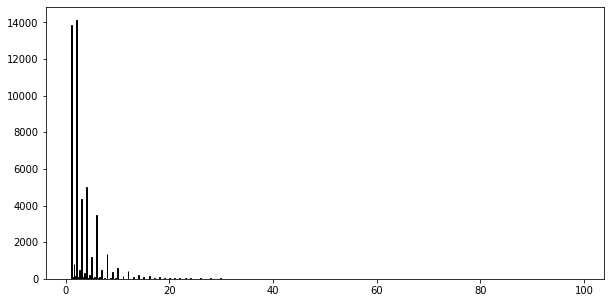

In [42]:
for col in data.columns:
    plt.figure(figsize=(10, 5))
    
    # Пропускаем столбцы с типом datetime
    if data[col].dtype == 'datetime64[ns]':
        print(f"Пропускаем {col} - тип datetime")
        plt.close()  # Закрываем пустую фигуру
        continue
    
    try:
        # Для числовых данных
        if data[col].dtype in ['int64', 'float64']:
            sns.histplot(data=data, x=col, kde=True)
            plt.title(f'Распределение: {col}')
            plt.xlabel(col)
            plt.ylabel('Частота')
        # Для категориальных (object) данных
        elif data[col].dtype == 'object':
            # Для категориальных данных лучше использовать countplot
            sns.countplot(data=data, x=col)
            plt.title(f'Распределение: {col}')
            plt.xlabel(col)
            plt.ylabel('Количество')
        else:
            # Для остальных типов пропускаем
            print(f"Пропускаем {col} - тип {data[col].dtype}")
            plt.close()
            continue
            
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Ошибка при построении графика для {col}: {str(e)}")
        plt.close()
        continue

## Пайплан, разделение данных и модели

In [43]:
data

,client_id,target,total_quantity,max_quantity,std_quantity,mean_price,median_price,max_price,total_revenue,mean_revenue_per_item,...,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,open_rate,click_rate,purchase_rate_event
0,1515915625468060902,0,7,1,0.0,999.000000,999.0,1999.0,6993.0,999.000000,...,5.0,126.0,0.0,0.0,1.0,177.0,0.0,0.0,0.0,0.0
1,1515915625468061003,1,7,1,0.0,2319.285714,2100.0,3499.0,16235.0,2319.285714,...,1.0,154.0,0.0,0.0,0.0,166.0,0.0,0.0,0.0,0.0
2,1515915625468061099,0,1,1,0.0,299.000000,299.0,299.0,299.0,299.000000,...,0.0,215.0,0.0,0.0,0.0,182.0,94.0,0.0,0.0,0.0
3,1515915625468061100,0,2,1,0.0,1049.000000,1049.0,1049.0,2098.0,1049.000000,...,1.0,267.0,1.0,0.0,0.0,0.0,434.0,0.0,0.0,0.0
4,1515915625468061170,0,19,1,0.0,1768.473684,2195.0,2699.0,33601.0,1768.473684,...,3.0,243.0,0.0,0.0,0.0,202.0,91.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49844,1515915626010261344,0,6,1,0.0,1499.000000,1499.0,1499.0,8994.0,1499.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
49845,1515915626010266132,0,2,1,0.0,909.000000,909.0,909.0,1818.0,909.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49846,1515915626010439406,0,2,1,0.0,99.000000,99.0,99.0,198.0,99.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49847,1515915626010443527,0,1,1,0.0,1999.000000,1999.0,1999.0,1999.0,1999.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('target', axis=1),
    data['target'],
    test_size = VALID_SIZE,
    random_state = RANDOM_STATE,
    stratify = data['target'])

In [ ]:
num_cols = data.columns

In [45]:
data_preprocessor = ColumnTransformer(
    [('num', StandardScaler(), num_cols)],
    remainder='passthrough'
) 

NameError: name 'num_cols' is not defined

In [46]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression())
])

NameError: name 'data_preprocessor' is not defined

In [ ]:
param_grid1 = [
    {
    'models': [LogisticRegression(penalty='l2', random_state=RANDOM_STATE, max_iter=1000)],
    'models__C': np.arange(0.1, 2.1, 0.2).tolist(),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LGBMClassifier()],
        'models__n_estimators': range(10,1000, 5),
        'models__max_depth': range(2,25),
        'models__learning_rate': np.arange(0.2, 1, 0.2).tolist(),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'], 
    },
    
] 

In [ ]:
cb = CatBoostClassifier(verbose=0, random_seed=RANDOM_STATE)

cb_param = {
    'depth': range(1,25),
    'learning_rate': np.arange(0.2, 1, 0.2).tolist(),
    'iterations': range(10,1000, 5),
}


cb_search = RandomizedSearchCV(
    estimator=cb,
    param_distributions=cb_param,
    n_iter=3,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

### Обучение, тест и метрика:

In [ ]:
start_time = time.time()

random_search1 = RandomizedSearchCV(
    pipe_final,
    param_grid1,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=3 
)
random_search1.fit(X_train, y_train)

end_time = time.time()
total_time = end_time - start_time
print(f"Время подбора гиперпараметров: {total_time:.2f} секунд")